# Frost heave compaction solver

This notebook solves a frost heave compaction problem in one spatial dimension (vertical). 

The code requires [FEniCSx](https://fenicsproject.org). The notebook can be run 
through a [Docker](https://www.docker.com) container with the command:

`docker run --init -ti -p 8888:8888 -v $(pwd):/home/fenics/shared -w /home/fenics/shared dolfinx/lab:stable`

Various imports:

In [1]:
%load_ext autoreload
%autoreload 2
# add path to code
import sys
sys.path.insert(0, '../source')

In [2]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import numpy as np
from dolfinx.fem import Function, FunctionSpace
from dolfinx.mesh import create_interval
from constitutive import Phi, sat, temp, D, perm,sign
from mpi4py import MPI
from params import nz
from petsc4py import PETSc
from solvers import initialize,solve_pde, time_stepping
from ufl import FiniteElement, MixedElement, Dx, SpatialCoordinate
from plotting import plot, plot_steady
from post_process import interp
from scipy.interpolate import interp1d
# import sympy as sp

Define domain:

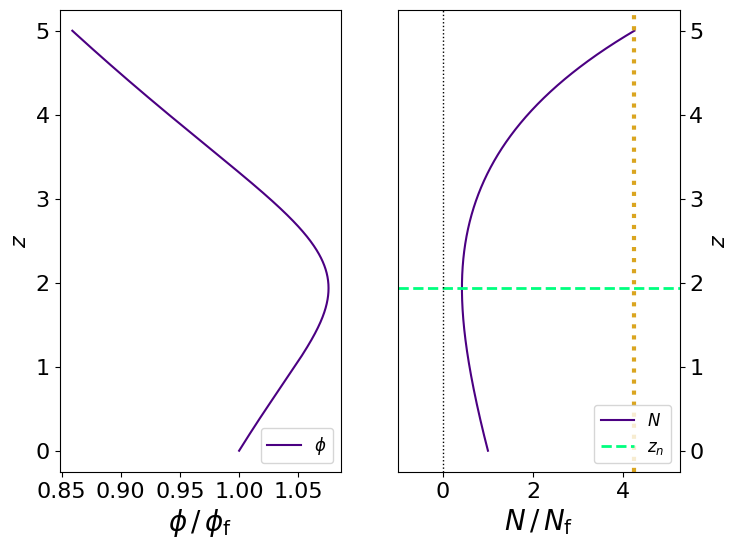

In [3]:
# generate mesh
N_f = 2  # effective stress at base of fringe 
z_l = 5
z_b = 1e-3
domain = create_interval(MPI.COMM_WORLD,nz,[z_b,z_l])

# define initial condition N that satisfies the
# elliptic problem: D(phi,S) N']' = F(phi,S)   
# which is valid for rigid solutions (dN/dt + v_i dN/dz = 0)
initial = initialize(domain,N_f,eps_min=1e-10)

# interpolate solution, save in numpy arrays, and plot
z,N = interp(initial,domain)
plot_steady(N,z)

In [ ]:
# set pulling speed and timesteps 
v_i = 0.039
timesteps = np.linspace(0,4e3,6000)

# solve the time-dependent problem
N,z,new_lens,heave,converged = time_stepping(domain,initial,N_f,v_i,timesteps,eps=1e-10)

In [ ]:
# plot solution up to first ice lens initiation
l0 = np.where(new_lens==1)[0]
if np.size(l0)== 0:
    l0 = None
else:
    l0 = l0[0]
plot(N,z,timesteps[0:l0])

In [ ]:
# plot position of active ice lens over time
z_l = np.max(z,axis=1)
old_lens = np.roll(new_lens,-1)

plt.figure(figsize=(8,6))
plt.subplot(211)
plt.plot(timesteps/timesteps.max(),z_l,'o',markersize=2,color='gray')
plt.plot(timesteps[new_lens==1]/timesteps.max(),z_l[new_lens==1],'*',markersize=8,color='crimson',label=r'$z_\mathrm{n}$')
plt.plot(timesteps[old_lens==1]/timesteps.max(),z_l[old_lens==1],'*',markersize=8,color='darkblue',label=r'$z_\ell^\star$')

if converged == False:
    plt.plot(timesteps[l0+1:None]/timesteps.max(),z_l[l0+1:None],'x',markersize=5)
    
plt.legend(fontsize=12,loc='lower right',ncol=1)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel(r'$z_\ell$',fontsize=16)
plt.ylim(np.mean(z_l)-3*np.std(z_l),np.mean(z_l)+3*np.std(z_l))

plt.gca().xaxis.set_ticklabels([])

plt.subplot(212)
heave_lens = heave[:,-1]
heave_base = heave[:,2]
heave_mean = np.mean(heave,axis=1)
heave_max = np.max(heave,axis=1)

heave_min = 0*heave[:,0]
val = 0
for i in range(heave_min.size):
    heave_min[i] = val
    if np.size(heave[i,:][heave[i,:]!=0])>0:
        val = np.min(heave[i,:][heave[i,:]!=0])
        heave_min[i] = val

# plt.plot(timesteps[heave_base!=0]/timesteps.max(),heave_base[heave_base!=0],'o',markersize=3,color='forestgreen',label=r'base')
plt.plot(timesteps[heave_max!=0]/timesteps.max(),heave_max[heave_max!=0],'o',markersize=1,color='gray',label=r'max')

plt.plot(timesteps[heave_lens!=0]/timesteps.max(),heave_lens[heave_lens!=0],'o',markersize=2,color='crimson',label=r'lens')
plt.plot(timesteps[heave_mean!=0]/timesteps.max(),heave_mean[heave_mean!=0],'o',markersize=2,color='darkblue',label=r'mean')
plt.plot(timesteps[heave_min!=0]/timesteps.max(),heave_min[heave_min!=0],'o',markersize=2,color='forestgreen',label=r'min')
plt.axhline(0,linewidth=1,linestyle='--',color='k')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel(r'${v}_*$',fontsize=16)
plt.legend(fontsize=12,loc='upper right',ncol=1)

plt.xlabel(r'$t\,/\,t_\mathrm{max}$',fontsize=20)  
plt.show()
plt.close()

In [ ]:
l0 = np.where(new_lens==1)[0]
i0 = l0[13]
i1 = l0[14]
q = (1-Phi(N,log=np.log)*sat(temp(z)))*heave
q_mean = np.mean(q[i0:i1,:],axis=0)
z_mean = np.mean(z[i0:i1,:],axis=0)

plt.figure(figsize=(6,4))
plt.plot(q_mean,z_mean,color='k',linewidth=3)
# plt.plot(heave,z,linewidth=1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel(r'$z$',fontsize=16)
plt.xlabel(r'$q$',fontsize=20)
plt.show()
plt.close()